In [1]:
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh import extract_features
from tsfresh.feature_extraction.feature_calculators import set_property
import pycatch22

from autogluon.tabular import TabularPredictor
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = 'Arial'

## 0. some functions

### 0.1 tsfresh featurization 

In [2]:
@set_property("fctype", "combiner")
def catch22(x, param):
    """
    pycatch22, a Python library that wraps the CATCH time series characteristics

    Lubba et al. catch22: CAnonical Time-series CHaracteristics, Data Min Knowl Disc 33, 1821 (2019).

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: list of tuples (s, f) where s are the feature name in catch22, serialized as a string,
             and f the respective feature value as bool, int or float
    :return type: pandas.Series
    """
    data = pycatch22.catch22_all(x)

    return [(name, value) for name, value in zip(data['names'], data['values'])]

settings = ComprehensiveFCParameters()
settings[catch22] = None


def conc_points2raw_data(conc_points:dict, sp_mode='sp')->pd.DataFrame:
    data_column = ['id']
    if 's' in sp_mode:
        for i in range(30):
            data_column += [f's{i}']
    if 'p' in sp_mode:
        for i in range(30):
            data_column += [f'p{i}']
    data = pd.DataFrame(columns=data_column)
    cnt = 0
    for idx in conc_points:
        data.loc[cnt, 'id'] = idx
        for i in range(30):
            if 's' in conc_points[idx]:
                data.loc[cnt, f's{i}'] = conc_points[idx]['s'][i]
            if 'p' in conc_points[idx]:
                data.loc[cnt, f'p{i}'] = conc_points[idx]['p'][i]
        cnt += 1
    return data


def preprocess_data_for_tsfresh(data:pd.DataFrame, sp_mode='sp')->pd.DataFrame:
    
    if sp_mode == 'sp':
        data_tsfresh = pd.DataFrame(columns=['id', 't', 's', 'p'])
        data_tsfresh_ids = []
        data_tsfresh_ts = []
        data_tsfresh_ss = []
        data_tsfresh_ps = []
        for i in range(data.shape[0]):
            id = data.loc[i, 'id']
            for j in range(30):
                data_tsfresh_ss.append(data.loc[i, f's{j}'])
                data_tsfresh_ps.append(data.loc[i, f'p{j}'])
            data_tsfresh_ids += [id] * 30
            data_tsfresh_ts += list(range(30))
        data_tsfresh['id'] = data_tsfresh_ids
        data_tsfresh['t'] = data_tsfresh_ts
        data_tsfresh['s'] = data_tsfresh_ss
        data_tsfresh['p'] = data_tsfresh_ps

        return data_tsfresh
    
    elif sp_mode == 's':
        data_tsfresh = pd.DataFrame(columns=['id', 't', 's'])
        data_tsfresh_ids = []
        data_tsfresh_ts = []
        data_tsfresh_ss = []
        for i in range(data.shape[0]):
            id = data.loc[i, 'id']
            for j in range(30):
                data_tsfresh_ss.append(data.loc[i, f's{j}'])
            data_tsfresh_ids += [id] * 30
            data_tsfresh_ts += list(range(30))
        data_tsfresh['id'] = data_tsfresh_ids
        data_tsfresh['t'] = data_tsfresh_ts
        data_tsfresh['s'] = data_tsfresh_ss

        return data_tsfresh
    
    elif sp_mode == 'p':
        data_tsfresh = pd.DataFrame(columns=['id', 't', 'p'])
        data_tsfresh_ids = []
        data_tsfresh_ts = []
        data_tsfresh_ps = []
        for i in range(data.shape[0]):
            id = data.loc[i, 'id']
            for j in range(30):
                data_tsfresh_ps.append(data.loc[i, f'p{j}'])
            data_tsfresh_ids += [id] * 30
            data_tsfresh_ts += list(range(30))
        data_tsfresh['id'] = data_tsfresh_ids
        data_tsfresh['t'] = data_tsfresh_ts
        data_tsfresh['p'] = data_tsfresh_ps

        return data_tsfresh
    
    else:
        raise ValueError('sp_mode can only be sp, s, or p')


def get_tsfresh_features(conc_points:dict, sp_mode='sp')->pd.DataFrame:
    
    data = conc_points2raw_data(conc_points, sp_mode=sp_mode)
    data_tsfresh = preprocess_data_for_tsfresh(data, sp_mode=sp_mode)
    data_tsfresh = extract_features(data_tsfresh, column_id='id', column_sort='t', default_fc_parameters=settings)
    data_tsfresh['id'] = data_tsfresh.index
    data_tsfresh = data_tsfresh.reset_index(drop=True)
    # move id to the first column
    cols = list(data_tsfresh)
    cols.insert(0, cols.pop(cols.index('id')))
    data_tsfresh = data_tsfresh.loc[:, cols]
    return data_tsfresh

### 0.2 data preprocess

In [3]:
def time_conc_curve_fit(time, conc, max_degree=3, verbose=False):

    for degree in range(1, max_degree+1):
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        time_poly = poly_features.fit_transform(time.reshape(-1, 1))

        # polynomial regression
        model = LinearRegression()
        model.fit(time_poly, conc)

        # predict
        time_plot = time.reshape(-1, 1)
        time_plot_poly = poly_features.transform(time_plot)
        conc_plot = model.predict(time_plot_poly)

        mse = mean_squared_error(conc, conc_plot)
        if degree == 1:
            best_mse = mse
            best_degree = degree
            best_model = model
        else:
            if mse < best_mse:
                best_mse = mse
                best_degree = degree
                best_model = model
    if verbose:
        print('best degree:', best_degree)
        print('best mse:', best_mse)

    return best_model, best_degree


def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))


def judege_cat_eq(cat_eq):
    higher_cat_eq = 0.1
    norm_cat_eq = 0.01
    lower_cat_eq = 0.001
    if np.log10(cat_eq) >= np.log10(higher_cat_eq):
        return 'higher_cat'
    elif np.log10(cat_eq) >= np.log10(norm_cat_eq):
        if abs(np.log10(cat_eq) - np.log10(norm_cat_eq)) > abs(np.log10(cat_eq) - np.log10(higher_cat_eq)):
            return 'higher_cat'
        else:
            return 'norm_cat'
    elif np.log10(cat_eq) >= np.log10(lower_cat_eq):
        if abs(np.log10(cat_eq) - np.log10(lower_cat_eq)) > abs(np.log10(cat_eq) - np.log10(norm_cat_eq)):
            return 'norm_cat'
        else:
            return 'lower_cat'
    else:
        return 'lower_cat'
    

def is_quick_rxn(time, conc, obj='s', time_threshold=2/3, conc_threshold=0.05):
    '''
    If the reaction is completed (concentration of substrate less than 0.05) within 2/3 of the total time, return True
    '''
    if obj == 's':
        for t, c in zip(time, conc):
            if t < time_threshold:
                if c < conc_threshold: return True
            else: return False

    elif obj == 'p':
        conc_threshold = 1 - conc_threshold
        for t, c in zip(time, conc):
            if t < time_threshold:
                if c > conc_threshold: return True
            else: return False


def cut_rxn_time(time, conc, obj='s', time_threshold=2/3, conc_threshold=0.05):
    '''
    Cut the reaction time and concentration data one by one from the last point until the reaction is not quick
    '''
    while is_quick_rxn(time, conc, obj=obj, time_threshold=time_threshold, conc_threshold=conc_threshold):
        time = normalize(time[:-1])
        conc = conc[:-1]
    return time, conc


def is_completed_rxn(conc, obj='s', conc_threshold=0.5):
    '''
    If the final substrate concentration is less than 0.5, return True
    '''
    if obj == 's':
        for c in conc:
            if c < conc_threshold: return True
        return False

    elif obj == 'p':
        print('NOTE: be careful when using is_completed_rxn() with Product Conc., e.g. 2 eq. rxn')
        conc_threshold = 1 - conc_threshold
        for c in conc:
            if c > conc_threshold: return True
        return False


def generate_time_conc_curve(
    time, 
    conc,
    max_degree=6,
    plot_fit_str: str | None = None, 
    verbose = False,
    fit=True,
):
    if fit:
        model, degree = time_conc_curve_fit(time, conc, max_degree=max_degree, verbose=verbose)
        time_point = np.linspace(time.min(), time.max(), 30)
        conc_point = model.predict(PolynomialFeatures(degree=degree, include_bias=False).fit_transform(time_point.reshape(-1, 1)))

        if plot_fit_str:
            sns.scatterplot(x=time, y=conc, label=f'{plot_fit_str}')
            sns.lineplot(x=time_point, y=conc_point, label=f'{plot_fit_str}_fit')
            plt.legend(
                loc='upper right',
                bbox_to_anchor=(1.3, 1),
            )
        return time_point, conc_point
    else:
        # reserve 30 point averagely
        time_point = np.linspace(time.min(), time.max(), 30)
        conc_point = np.interp(time_point, time, conc)
        if plot_fit_str:
            sns.scatterplot(x=time, y=conc, label=f'{plot_fit_str}', legend=False)
            sns.lineplot(x=time_point, y=conc_point, label=f'{plot_fit_str}_fit')
        return time_point, conc_point

    
def get_top_x_probs(df, x=3):
    results = {}
    for i in range(1, x+1):
        results[f'list_indices_{i}'] = []
        results[f'list_probs_{i}'] = []
    for _, row in df.iterrows():
        top_x_values = row.nlargest(x).dropna().values
        top_x_indices = row.nlargest(x).index

        for i, (value, index) in enumerate(zip(top_x_values, top_x_indices)):
            results[f'list_indices_{i+1}'].append(index)
            results[f'list_probs_{i+1}'].append(value)
    
    return results

## 1. Prepare experimental data

### 1.1 load experimental data
- `sp_mode`: `s` (only use substrate concentration)

In [ ]:
sp_mode = 's'
df_exp = pd.read_csv('./experimental_data/data.csv')
df_exp

time_M1      S_M1  time_M2     S_M2  time_M3      S_M3  time_M4     S_M4  \
0        0.0  0.200392      0.0  0.15424      0.0  0.091202      0.0  0.19821   
1        1.0  0.198946      1.0  0.15382      1.0  0.090167      1.0  0.19689   
2        2.0  0.196392      2.0  0.15359      2.0  0.089711      2.0  0.19650   
3        3.0  0.192915      3.0  0.15331      3.0  0.090060      3.0  0.19488   
4        4.0  0.188915      4.0  0.15263      4.0  0.088765      4.0  0.19477   
..       ...       ...      ...      ...      ...       ...      ...      ...   
618      NaN       NaN      NaN      NaN      NaN       NaN      NaN      NaN   
619      NaN       NaN      NaN      NaN      NaN       NaN      NaN      NaN   
620      NaN       NaN      NaN      NaN      NaN       NaN      NaN      NaN   
621      NaN       NaN      NaN      NaN      NaN       NaN      NaN      NaN   
622      NaN       NaN      NaN      NaN      NaN       NaN      NaN      NaN   

     time_M5     S_M5  time_M6     S_M6  time_M7      S_M7  
0        0.0  0.11851      0.0  0.18959        0  0.173485  
1        1.0  0.11909      1.0  0.18827        1  0.172805  
2        2.0  0.11803      2.0  0.18624        2  0.172297  
3        3.0  0.11761      3.0  0.18535        3  0.172854  
4        4.0  0.11682      4.0  0.18385        4  0.171546  
..       ...      ...      ...      ...      ...       ...  
618      NaN      NaN      NaN      NaN      618  0.080156  
619      NaN      NaN      NaN      NaN      619  0.079472  
620      NaN      NaN      NaN      NaN      620  0.079252  
621      NaN      NaN      NaN      NaN      621  0.078321  
622      NaN      NaN      NaN      NaN      622  0.079007  

[623 rows x 14 columns]

### 1.2 read raw data, normalize time and concentration

In [5]:
time_M1 = normalize(df_exp['time_M1'].dropna().values)
s_conc_M1 = (df_exp['S_M1'].dropna().values - df_exp['S_M1'].dropna().values[-1]) / (df_exp['S_M1'].dropna().values[0] - df_exp['S_M1'].dropna().values[-1])

time_M2 = normalize(df_exp['time_M2'].dropna().values)
s_conc_M2 = (df_exp['S_M2'].dropna().values - df_exp['S_M2'].dropna().values[-1]) / (df_exp['S_M2'].dropna().values[0] - df_exp['S_M2'].dropna().values[-1])

time_M3 = normalize(df_exp['time_M3'].dropna().values)
s_conc_M3 = (df_exp['S_M3'].dropna().values - df_exp['S_M3'].dropna().values[-1]) / (df_exp['S_M3'].dropna().values[0] - df_exp['S_M3'].dropna().values[-1])

time_M4 = normalize(df_exp['time_M4'].dropna().values)
s_conc_M4 = (df_exp['S_M4'].dropna().values - df_exp['S_M4'].dropna().values[-1]) / (df_exp['S_M4'].dropna().values[0] - df_exp['S_M4'].dropna().values[-1])

time_M5 = normalize(df_exp['time_M5'].dropna().values)
s_conc_M5 = (df_exp['S_M5'].dropna().values - df_exp['S_M5'].dropna().values[-1]) / (df_exp['S_M5'].dropna().values[0] - df_exp['S_M5'].dropna().values[-1])

time_M6 = normalize(df_exp['time_M6'].dropna().values)
s_conc_M6 = (df_exp['S_M6'].dropna().values - df_exp['S_M6'].dropna().values[-1]) / (df_exp['S_M6'].dropna().values[0] - df_exp['S_M6'].dropna().values[-1])

time_M7 = normalize(df_exp['time_M7'].dropna().values)
s_conc_M7 = (df_exp['S_M7'].dropna().values - df_exp['S_M7'].dropna().values[-1]) / (df_exp['S_M7'].dropna().values[0] - df_exp['S_M7'].dropna().values[-1])


### 1.3 check data if it is quick rxn or uncompleted rxn

In [6]:
def check_data(time, conc, name, obj='s'):
    '''
    check if the reaction is quick rxn (need to cut), and completed rxn.
    '''
    if is_quick_rxn(time, conc, obj='s'):
        print(f'{name} is quick rxn')
        time, conc = cut_rxn_time(time, conc, obj='s')
        print(f'{name} has been cut')
    else:
        print(f'{name} is fine')

    if is_completed_rxn(conc, obj='s'):
        print(f'{name} is completed rxn')
    else:
        print(f'{name} is not completed rxn')

    return time, conc

time_M1, s_conc_M1 = check_data(time_M1, s_conc_M1, 'M1')
print('====================')
time_M2, s_conc_M2 = check_data(time_M2, s_conc_M2, 'M2')
print('====================')
time_M3, s_conc_M3 = check_data(time_M3, s_conc_M3, 'M3')
print('====================')
time_M4, s_conc_M4 = check_data(time_M4, s_conc_M4, 'M4')
print('====================')
time_M5, s_conc_M5 = check_data(time_M5, s_conc_M5, 'M5')
print('====================')
time_M6, s_conc_M6 = check_data(time_M6, s_conc_M6, 'M6')
print('====================')
time_M7, s_conc_M7 = check_data(time_M7, s_conc_M7, 'M7')
print('====================')


M1 is fine
M1 is completed rxn
M2 is fine
M2 is completed rxn
M3 is quick rxn
M3 has been cut
M3 is completed rxn
M4 is fine
M4 is completed rxn
M5 is fine
M5 is completed rxn
M6 is fine
M6 is completed rxn
M7 is fine
M7 is completed rxn


### 1.4 fit the time-concentration data with polynomial, to obtain 30 data points with equal intervals.

best degree: 6
best mse: 1.9701417250808083e-05
best degree: 6
best mse: 1.739671049348721e-05
best degree: 6
best mse: 0.00014255534281661499
best degree: 6
best mse: 2.8131581187539527e-05
best degree: 6
best mse: 3.468771967545782e-05
best degree: 6
best mse: 7.946397001679069e-06
best degree: 6
best mse: 7.572331808768317e-05


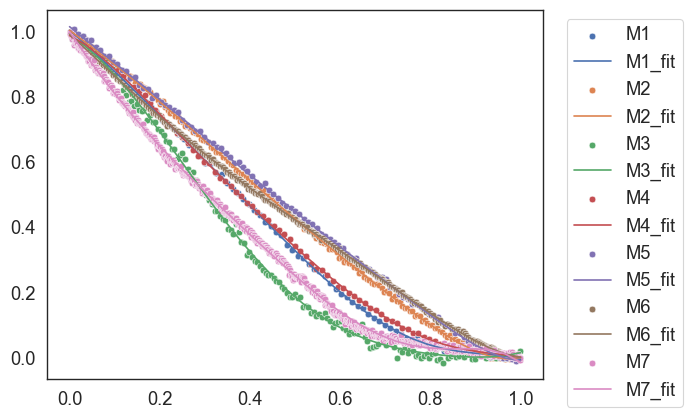

In [7]:
max_degree = 6
fit = True
time_point_M1, s_conc_point_M1 = generate_time_conc_curve(time_M1, s_conc_M1, plot_fit_str='M1', verbose=True, fit=True)
time_point_M2, s_conc_point_M2 = generate_time_conc_curve(time_M2, s_conc_M2, plot_fit_str='M2', verbose=True, fit=True)
time_point_M3, s_conc_point_M3 = generate_time_conc_curve(time_M3, s_conc_M3, plot_fit_str='M3', verbose=True, fit=True)
time_point_M4, s_conc_point_M4 = generate_time_conc_curve(time_M4, s_conc_M4, plot_fit_str='M4', verbose=True, fit=True)
time_point_M5, s_conc_point_M5 = generate_time_conc_curve(time_M5, s_conc_M5, plot_fit_str='M5', verbose=True, fit=True)
time_point_M6, s_conc_point_M6 = generate_time_conc_curve(time_M6, s_conc_M6, plot_fit_str='M6', verbose=True, fit=True)
time_point_M7, s_conc_point_M7 = generate_time_conc_curve(time_M7, s_conc_M7, plot_fit_str='M7', verbose=True, fit=True)

### 1.5 featurize the data with tsfresh, merged with raw data

In [8]:
df_exp_tsfresh_data = get_tsfresh_features(
    {
        'M1': {'s': s_conc_point_M1},
        'M2': {'s': s_conc_point_M2},
        'M3': {'s': s_conc_point_M3},
        'M4': {'s': s_conc_point_M4},
        'M5': {'s': s_conc_point_M5},
        'M6': {'s': s_conc_point_M6},
        'M7': {'s': s_conc_point_M7},
    },
    sp_mode=sp_mode
)

df_exp_raw_data = conc_points2raw_data(
    {
        'M1': {'s': s_conc_point_M1},
        'M2': {'s': s_conc_point_M2},
        'M3': {'s': s_conc_point_M3},
        'M4': {'s': s_conc_point_M4},
        'M5': {'s': s_conc_point_M5},
        'M6': {'s': s_conc_point_M6},
        'M7': {'s': s_conc_point_M7},
    },
    sp_mode=sp_mode
)

df_exp_merged_data = pd.merge(df_exp_raw_data, df_exp_tsfresh_data, on='id')
df_exp_merged_data

Feature Extraction: 100%|██████████| 7/7 [00:00<00:00, 107.90it/s]


id        s0        s1        s2        s3        s4        s5        s6  \
0  M1  1.005133  0.963376  0.919357  0.873979  0.827816  0.781195   0.73427   
1  M2   1.00502  0.968922  0.932469  0.895212  0.856938  0.817611  0.777325   
2  M3   0.99034  0.956373  0.913715  0.863485   0.80701  0.745742  0.681194   
3  M4  0.989088  0.961654  0.925032  0.882289  0.835752  0.787128  0.737621   
4  M5  1.016177  0.977115  0.938963  0.900986  0.862735  0.823989  0.784697   
5  M6  0.993381  0.949088  0.904572  0.860268  0.816538  0.773667  0.731867   
6  M7  1.000863  0.932097  0.866553  0.804666  0.746448   0.69161  0.639677   

         s7        s8  ... s__catch22__FC_LocalSimple_mean1_tauresrat  \
0  0.687083  0.639622  ...                                   0.818182   
1  0.736263  0.694654  ...                                   0.818182   
2  0.614878  0.548249  ...                                   0.909091   
3  0.688037  0.638875  ...                                   0.818182   
4  0.744929  0.704835  ...                                   0.909091   
5  0.691278  0.651971  ...                                   1.090909   
6  0.590078  0.542236  ...                                   0.909091   

  s__catch22__DN_OutlierInclude_p_001_mdrmd  \
0                                 -0.700000   
1                                 -0.700000   
2                                 -0.733333   
3                                 -0.700000   
4                                 -0.700000   
5                                 -0.733333   
6                                 -0.733333   

  s__catch22__DN_OutlierInclude_n_001_mdrmd  \
0                                  0.633333   
1                                  0.700000   
2                                  0.566667   
3                                  0.633333   
4                                  0.733333   
5                                  0.733333   
6                                  0.600000   

  s__catch22__SP_Summaries_welch_rect_area_5_1  \
0                                     0.868675   
1                                     0.868486   
2                                     0.870942   
3                                     0.871427   
4                                     0.859135   
5                                     0.848478   
6                                     0.841419   

  s__catch22__SB_BinaryStats_diff_longstretch0  \
0                                         28.0   
1                                         28.0   
2                                         26.0   
3                                         28.0   
4                                         28.0   
5                                         28.0   
6                                         25.0   

  s__catch22__SB_MotifThree_quantile_hh  \
0                              1.321604   
1                              1.321604   
2                              1.321604   
3                              1.321604   
4                              1.321604   
5                              1.321604   
6                              1.321604   

  s__catch22__SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1  \
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        
5                                                0.0        
6                                                0.0        

  s__catch22__SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
5                                                0.0   
6  

## 2. Predict on wet-lab data using 5-class model
- `feat`: `tsfresh_raw` (use both tsfresh features and raw data)
- `ag_train_quality`: `best_quality` (use `best_quality` present in Autogluon training)
- `hours`: `3` (train for 3 hours)

In [9]:
class_5_list = [
    'zero',
    'mm_1',
    # 'mm_1_out',
    'first',
    'mm_2',
    'second',
]
class_num = len(class_5_list)

ag_model_root = './AutogluonModels/'
feat = 'tsfresh_raw'
ag_train_quality = 'best_quality'
hours = 3.0
label_col = 'class'
random_seed = 29

### 2.1 load model

In [10]:
model_5_class_root = os.path.join(ag_model_root, f'{str(class_num)}_class', f'{feat}_feat__{sp_mode}__{ag_train_quality}__{hours}h')
predictor_5_class = TabularPredictor.load(model_5_class_root)

### 2.2 predict and show the result

In [11]:
exp_proba_5_class = predictor_5_class.predict_proba(df_exp_merged_data)

In [12]:
df_exp_pred_results_5_class = pd.DataFrame({
    'id': df_exp_merged_data['id'],
    'pred_1st': get_top_x_probs(exp_proba_5_class, x=1)['list_indices_1'],
    'pred_1st_proba': get_top_x_probs(exp_proba_5_class, x=1)['list_probs_1'],
    'pred_2nd': get_top_x_probs(exp_proba_5_class, x=2)['list_indices_2'],
    'pred_2nd_proba': get_top_x_probs(exp_proba_5_class, x=2)['list_probs_2'],
    'pred_3rd': get_top_x_probs(exp_proba_5_class, x=3)['list_indices_3'],
    'pred_3rd_proba': get_top_x_probs(exp_proba_5_class, x=3)['list_probs_3'],
    'pred_4th': get_top_x_probs(exp_proba_5_class, x=4)['list_indices_4'],
    'pred_4th_proba': get_top_x_probs(exp_proba_5_class, x=4)['list_probs_4'],
    'pred_5th': get_top_x_probs(exp_proba_5_class, x=5)['list_indices_5'],
    'pred_5th_proba': get_top_x_probs(exp_proba_5_class, x=5)['list_probs_5'],
})
df_exp_pred_results_5_class = df_exp_pred_results_5_class.round(3)
df_exp_pred_results_5_class

id pred_1st  pred_1st_proba pred_2nd  pred_2nd_proba pred_3rd  \
0  M1     mm_1           0.894     zero           0.049     mm_2   
1  M2     mm_1           0.658     zero           0.260   second   
2  M3     mm_1           0.915    first           0.025     mm_2   
3  M4     mm_1           0.931     zero           0.022     mm_2   
4  M5     mm_1           0.818     zero           0.114   second   
5  M6    first           0.907     mm_1           0.034     mm_2   
6  M7    first           0.896     mm_2           0.033     mm_1   

   pred_3rd_proba pred_4th  pred_4th_proba pred_5th  pred_5th_proba  
0           0.019   second           0.019    first           0.019  
1           0.028     mm_2           0.027    first           0.027  
2           0.021     zero           0.020   second           0.018  
3           0.016   second           0.016    first           0.016  
4           0.023     mm_2           0.023    first           0.023  
5           0.022   second           0.019     zero           0.018  
6           0.033   second           0.020     zero           0.018

In [ ]:
df_exp_pred_results_5_class_T = df_exp_pred_results_5_class.T
df_exp_pred_results_5_class_T

0       1       2       3       4       5       6
id                  M1      M2      M3      M4      M5      M6      M7
pred_1st          mm_1    mm_1    mm_1    mm_1    mm_1   first   first
pred_1st_proba   0.894   0.658   0.915   0.931   0.818   0.907   0.896
pred_2nd          zero    zero   first    zero    zero    mm_1    mm_2
pred_2nd_proba   0.049    0.26   0.025   0.022   0.114   0.034   0.033
pred_3rd          mm_2  second    mm_2    mm_2  second    mm_2    mm_1
pred_3rd_proba   0.019   0.028   0.021   0.016   0.023   0.022   0.033
pred_4th        second    mm_2    zero  second    mm_2  second  second
pred_4th_proba   0.019   0.027    0.02   0.016   0.023   0.019    0.02
pred_5th         first   first  second   first   first    zero    zero
pred_5th_proba   0.019   0.027   0.018   0.016   0.023   0.018   0.018

### 2.3 draw figures

In [14]:
exp_proba_5_class = exp_proba_5_class[class_5_list]
pie_data_5_class = {
    'M1': exp_proba_5_class.iloc[0].tolist(),
    'M2': exp_proba_5_class.iloc[1].tolist(),
    'M3': exp_proba_5_class.iloc[2].tolist(),
    'M4': exp_proba_5_class.iloc[3].tolist(),
    'M5': exp_proba_5_class.iloc[4].tolist(),
    'M6': exp_proba_5_class.iloc[5].tolist(),
    'M7': exp_proba_5_class.iloc[6].tolist(),
}
pie_colors_5_class = ['#79A1E3', '#FFA878', '#88D59A', '#E37275', '#AB9FD6']

#### 2.3.1 M1 (Figure 5c)

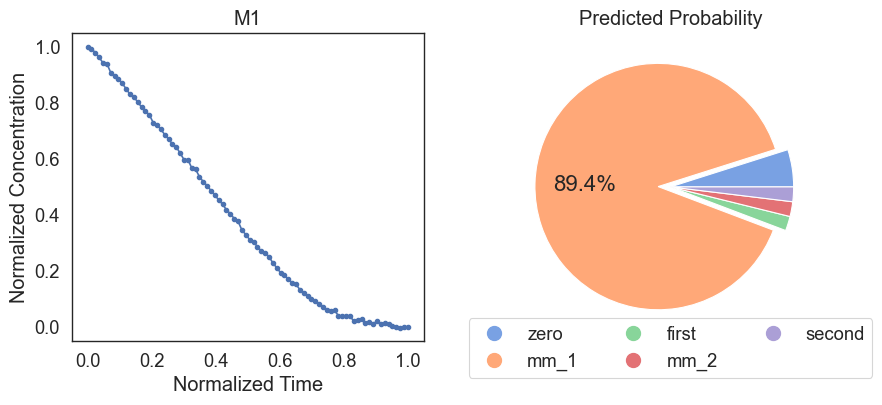

In [15]:
def autopct_only_max(pct, sizes):
    '''
    only show the percentage of the largest value
    '''
    value = pct / 100.0
    tolerance = 1e-3
    if abs(value - max(sizes)) < tolerance:
        return f'{pct:.1f}%'
    else:
        return ''

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(time_M1, s_conc_M1, 
            #  label='Experimental Data', 
             marker='o', markersize=3)
axes[0].set_title('M1')
axes[0].set_xlabel('Normalized Time')
axes[0].set_ylabel('Normalized Concentration')
axes[0].set_ylim(-0.05, 1.05)

explode = [0.1 if size == max(pie_data_5_class['M1']) else 0 for size in pie_data_5_class['M1']]

axes[1].pie(
    pie_data_5_class['M1'],
    autopct=lambda pct: autopct_only_max(pct, pie_data_5_class['M1']),
    startangle=0,
    colors=pie_colors_5_class,
    explode=explode,
    textprops={'fontsize': 16}
)
axes[1].set_title('Predicted Probability')
axes[1].legend(
    handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in pie_colors_5_class],
    labels=class_5_list,
    loc='lower center',           
    bbox_to_anchor=(0.5, -0.15), 
    ncol=3
    )

plt.show()

#### 2.3.2 M2-M6 (Figure 6a)

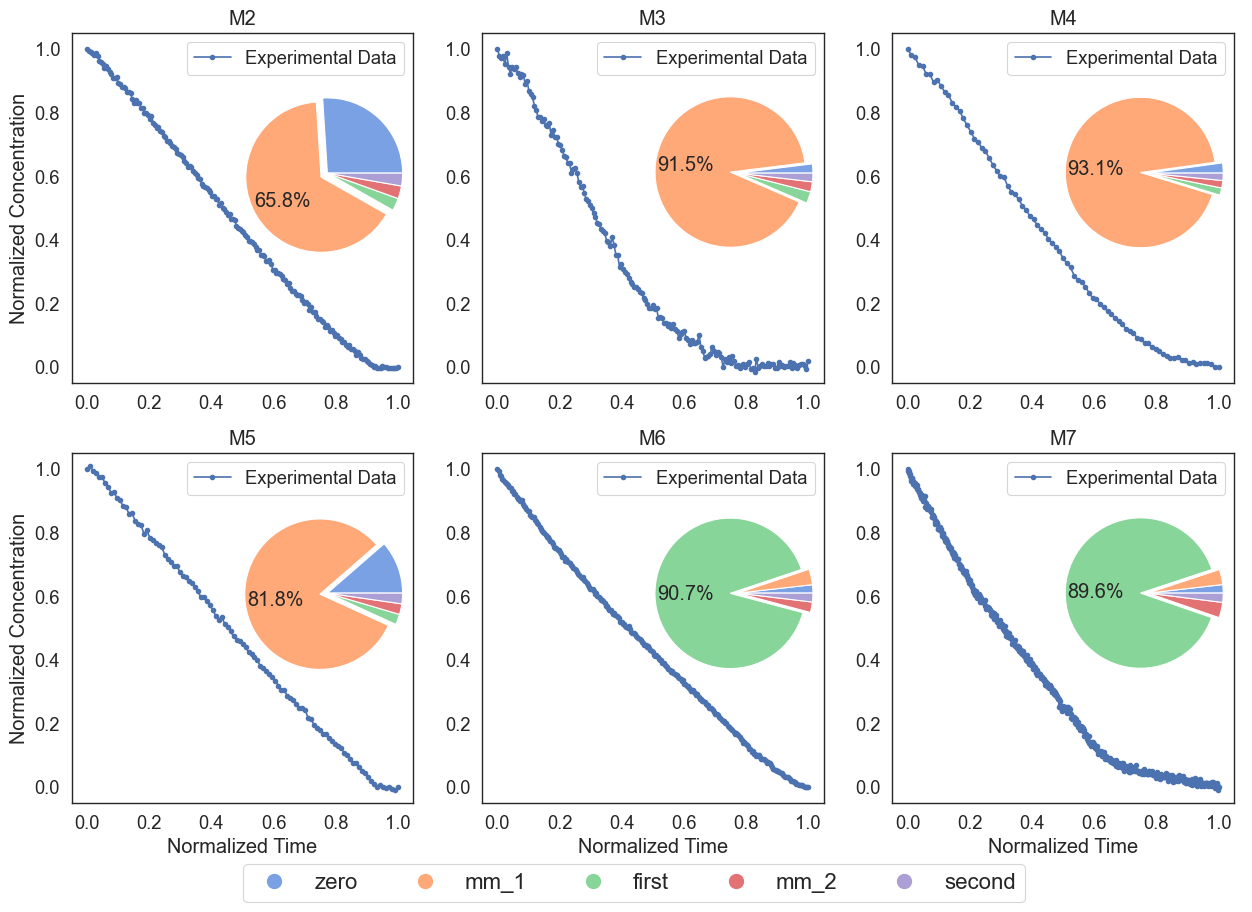

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def autopct_only_max(pct, sizes):
    '''
    only show the percentage of the largest value
    '''
    value = pct / 100.0
    tolerance = 1e-3
    if abs(value - max(sizes)) < tolerance:
        return f'{pct:.1f}%'
    else:
        return ''
    

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

s_conc_data = [s_conc_M2, s_conc_M3, s_conc_M4, s_conc_M5, s_conc_M6, s_conc_M7]
time_data = [time_M2, time_M3, time_M4, time_M5, time_M6, time_M7]
titles = ['M2', 'M3', 'M4', 'M5', 'M6', 'M7']

for i, ax in enumerate(axes):
    ax.plot(time_data[i], s_conc_data[i], label='Experimental Data', marker='o', markersize=3)
    ax.set_title(titles[i])
    ax.set_ylim(-0.05, 1.05)

    if i % 3 != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Normalized Concentration')

    if i < 3:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Normalized Time')
    ax.legend()

    inset_ax = inset_axes(ax, 
                      width="55%", 
                      height="55%", 
                      loc="center right", 
                      bbox_to_anchor=(0.05, 0.1, 1, 1),
                      bbox_transform=ax.transAxes)
    explode = [0.1 if size == max(pie_data_5_class[titles[i]]) else 0 for size in pie_data_5_class[titles[i]]]
    inset_ax.pie(
        pie_data_5_class[titles[i]],
        autopct=lambda pct: autopct_only_max(pct, pie_data_5_class[titles[i]]),
        startangle=0,
        colors=pie_colors_5_class,
        explode=explode,
    )

fig.legend(
    handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in pie_colors_5_class],
    labels=class_5_list,
    loc='lower center',          
    bbox_to_anchor=(0.5, 0),   
    ncol=6,
    fontsize=16,                   
)
plt.show()


## 3. Predict on wet-lab data using 6-class model
- `feat`: `tsfresh_raw` (use both tsfresh features and raw data)
- `ag_train_quality`: `best_quality` (use `best_quality` present in Autogluon training)
- `hours`: `3` (train for 3 hours)

In [17]:
class_6_list = [
    'zero',
    'mm_1',
    'mm_1_out',
    'first',
    'mm_2',
    'second',
]
class_num = len(class_6_list)

ag_model_root = './AutogluonModels/'
feat = 'tsfresh_raw'
ag_train_quality = 'best_quality'
hours = 3.0
label_col = 'class'
random_seed = 29

### 3.1 load model

In [18]:
model_6_class_root = os.path.join(ag_model_root, f'{str(class_num)}_class', f'{feat}_feat__{sp_mode}__{ag_train_quality}__{hours}h')
predictor_6_class = TabularPredictor.load(model_6_class_root)

### 3.2 predict and show the result

In [19]:
exp_proba_6_class = predictor_6_class.predict_proba(df_exp_merged_data)

In [20]:
df_exp_pred_results_6_class = pd.DataFrame({
    'id': df_exp_merged_data['id'],
    'pred_1st': get_top_x_probs(exp_proba_6_class, x=1)['list_indices_1'],
    'pred_1st_proba': get_top_x_probs(exp_proba_6_class, x=1)['list_probs_1'],
    'pred_2nd': get_top_x_probs(exp_proba_6_class, x=2)['list_indices_2'],
    'pred_2nd_proba': get_top_x_probs(exp_proba_6_class, x=2)['list_probs_2'],
    'pred_3rd': get_top_x_probs(exp_proba_6_class, x=3)['list_indices_3'],
    'pred_3rd_proba': get_top_x_probs(exp_proba_6_class, x=3)['list_probs_3'],
    'pred_4th': get_top_x_probs(exp_proba_6_class, x=4)['list_indices_4'],
    'pred_4th_proba': get_top_x_probs(exp_proba_6_class, x=4)['list_probs_4'],
    'pred_5th': get_top_x_probs(exp_proba_6_class, x=5)['list_indices_5'],
    'pred_5th_proba': get_top_x_probs(exp_proba_6_class, x=5)['list_probs_5'],
    'pred_6th': get_top_x_probs(exp_proba_6_class, x=6)['list_indices_6'],
    'pred_6th_proba': get_top_x_probs(exp_proba_6_class, x=6)['list_probs_6'],
})
df_exp_pred_results_6_class = df_exp_pred_results_6_class.round(3)
df_exp_pred_results_6_class

id  pred_1st  pred_1st_proba  pred_2nd  pred_2nd_proba  pred_3rd  \
0  M1      mm_1           0.797      zero           0.062      mm_2   
1  M2      mm_1           0.462      zero           0.352      mm_2   
2  M3      mm_1           0.776  mm_1_out           0.072      zero   
3  M4      mm_1           0.825      zero           0.040  mm_1_out   
4  M5      mm_1           0.553      zero           0.285      mm_2   
5  M6  mm_1_out           0.629     first           0.207      mm_2   
6  M7  mm_1_out           0.690     first           0.159      mm_2   

   pred_3rd_proba pred_4th  pred_4th_proba  pred_5th  pred_5th_proba pred_6th  \
0           0.036   second           0.035  mm_1_out           0.035    first   
1           0.047   second           0.047  mm_1_out           0.047    first   
2           0.044     mm_2           0.036    second           0.036    first   
3           0.037     mm_2           0.033    second           0.033    first   
4           0.041   second           0.041  mm_1_out           0.040    first   
5           0.042     mm_1           0.041    second           0.040     zero   
6           0.040     mm_1           0.037    second           0.037     zero   

   pred_6th_proba  
0           0.035  
1           0.046  
2           0.036  
3           0.033  
4           0.040  
5           0.039  
6           0.036

In [24]:
df_exp_pred_results_6_class_T = df_exp_pred_results_6_class.T
df_exp_pred_results_6_class_T

0         1         2         3         4         5  \
id                    M1        M2        M3        M4        M5        M6   
pred_1st            mm_1      mm_1      mm_1      mm_1      mm_1  mm_1_out   
pred_1st_proba     0.797     0.462     0.776     0.825     0.553     0.629   
pred_2nd            zero      zero  mm_1_out      zero      zero     first   
pred_2nd_proba     0.062     0.352     0.072      0.04     0.285     0.207   
pred_3rd            mm_2      mm_2      zero  mm_1_out      mm_2      mm_2   
pred_3rd_proba     0.036     0.047     0.044     0.037     0.041     0.042   
pred_4th          second    second      mm_2      mm_2    second      mm_1   
pred_4th_proba     0.035     0.047     0.036     0.033     0.041     0.041   
pred_5th        mm_1_out  mm_1_out    second    second  mm_1_out    second   
pred_5th_proba     0.035     0.047     0.036     0.033      0.04      0.04   
pred_6th           first     first     first     first     first      zero   
pred_6th_proba     0.035     0.046     0.036     0.033      0.04     0.039   

                       6  
id                    M7  
pred_1st        mm_1_out  
pred_1st_proba      0.69  
pred_2nd           first  
pred_2nd_proba     0.159  
pred_3rd            mm_2  
pred_3rd_proba      0.04  
pred_4th            mm_1  
pred_4th_proba     0.037  
pred_5th          second  
pred_5th_proba     0.037  
pred_6th            zero  
pred_6th_proba     0.036

### 3.3 draw figures

In [21]:
exp_proba_6_class = exp_proba_6_class[class_6_list]
pie_data_6_class = {
    'M1': exp_proba_6_class.iloc[0].tolist(),
    'M2': exp_proba_6_class.iloc[1].tolist(),
    'M3': exp_proba_6_class.iloc[2].tolist(),
    'M4': exp_proba_6_class.iloc[3].tolist(),
    'M5': exp_proba_6_class.iloc[4].tolist(),
    'M6': exp_proba_6_class.iloc[5].tolist(),
    'M7': exp_proba_6_class.iloc[6].tolist(),
}
pie_colors_6_class = ['#79A1E3', '#FFA878', '#F3CA79', '#88D59A', '#E37275', '#AB9FD6']

#### 3.3.1 M1

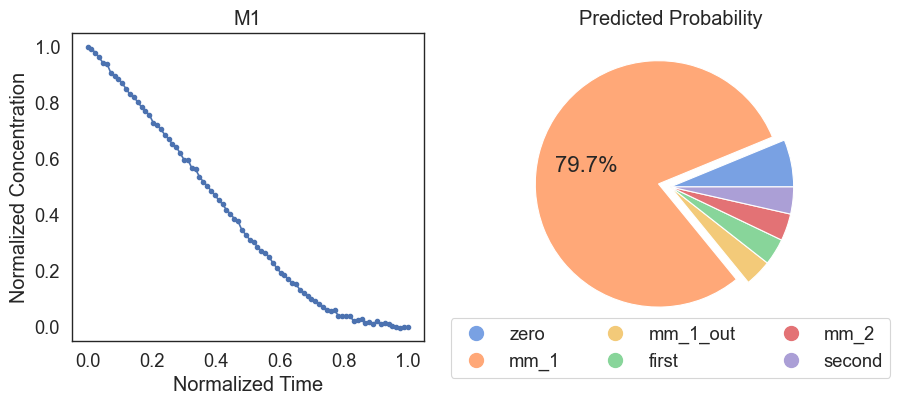

In [22]:
def autopct_only_max(pct, sizes):
    '''
    only show the percentage of the largest value
    '''
    value = pct / 100.0
    tolerance = 1e-3
    if abs(value - max(sizes)) < tolerance:
        return f'{pct:.1f}%'
    else:
        return ''

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(time_M1, s_conc_M1, 
            #  label='Experimental Data', 
             marker='o', markersize=3)
axes[0].set_title('M1')
axes[0].set_xlabel('Normalized Time')
axes[0].set_ylabel('Normalized Concentration')
axes[0].set_ylim(-0.05, 1.05)

explode = [0.1 if size == max(pie_data_6_class['M1']) else 0 for size in pie_data_6_class['M1']]

axes[1].pie(
    pie_data_6_class['M1'],
    autopct=lambda pct: autopct_only_max(pct, pie_data_6_class['M1']),
    startangle=0,
    colors=pie_colors_6_class,
    explode=explode,
    textprops={'fontsize': 16}
)
axes[1].set_title('Predicted Probability')
axes[1].legend(
    handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in pie_colors_6_class],
    labels=class_6_list,
    loc='lower center',           
    bbox_to_anchor=(0.5, -0.15), 
    ncol=3
    )

plt.show()

#### 3.3.2 M2-M6 (Figure 6c)

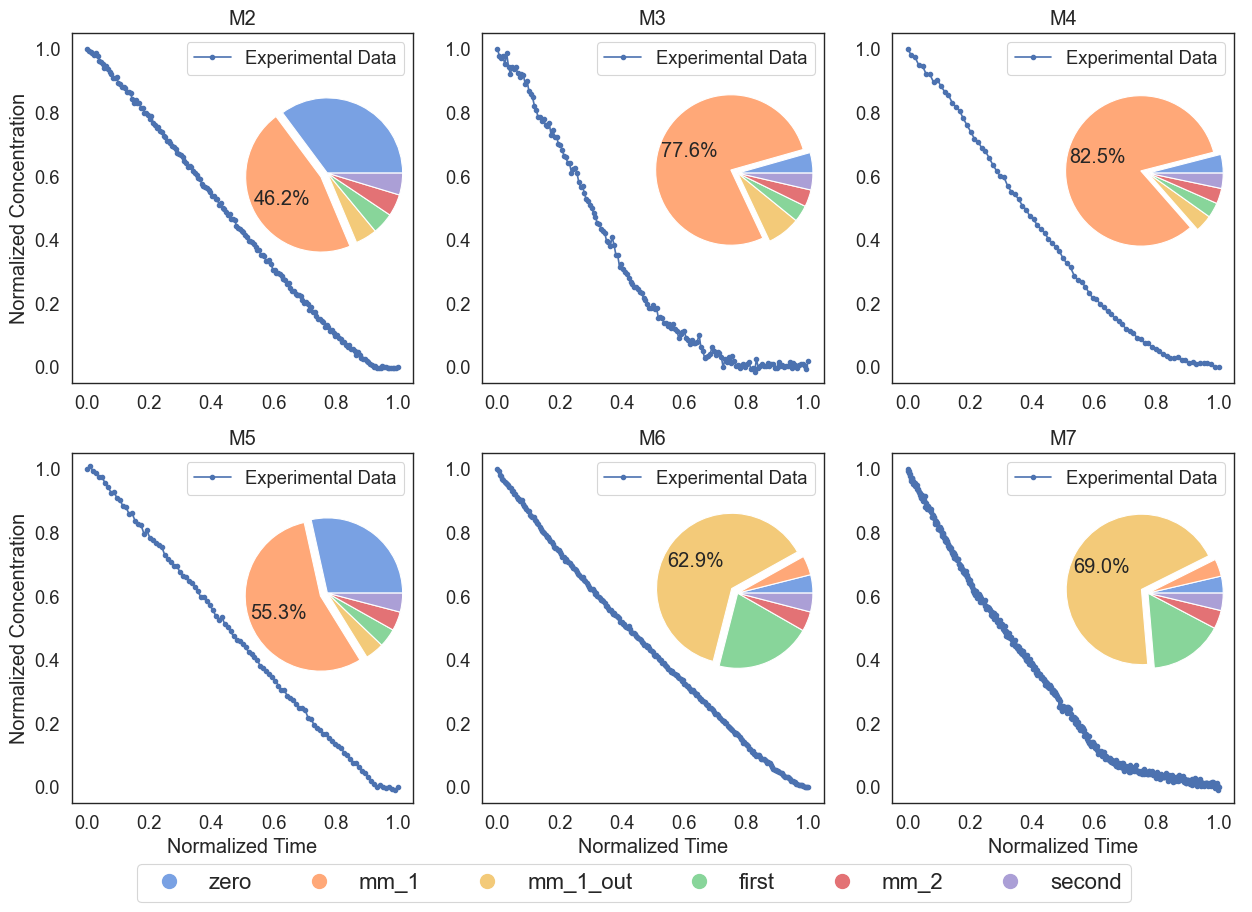

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def autopct_only_max(pct, sizes):
    '''
    only show the percentage of the largest value
    '''
    value = pct / 100.0
    tolerance = 1e-3
    if abs(value - max(sizes)) < tolerance:
        return f'{pct:.1f}%'
    else:
        return ''
    

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

s_conc_data = [s_conc_M2, s_conc_M3, s_conc_M4, s_conc_M5, s_conc_M6, s_conc_M7]
time_data = [time_M2, time_M3, time_M4, time_M5, time_M6, time_M7]
titles = ['M2', 'M3', 'M4', 'M5', 'M6', 'M7']

for i, ax in enumerate(axes):
    ax.plot(time_data[i], s_conc_data[i], label='Experimental Data', marker='o', markersize=3)
    ax.set_title(titles[i])
    ax.set_ylim(-0.05, 1.05)

    if i % 3 != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Normalized Concentration')

    if i < 3:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Normalized Time')
    ax.legend()

    inset_ax = inset_axes(ax, 
                      width="55%", 
                      height="55%", 
                      loc="center right", 
                      bbox_to_anchor=(0.05, 0.1, 1, 1),
                      bbox_transform=ax.transAxes)
    # inset_ax.set_facecolor('lightgrey')
    explode = [0.1 if size == max(pie_data_6_class[titles[i]]) else 0 for size in pie_data_6_class[titles[i]]]
    inset_ax.pie(
        pie_data_6_class[titles[i]],
        autopct=lambda pct: autopct_only_max(pct, pie_data_6_class[titles[i]]),
        startangle=0,
        colors=pie_colors_6_class,
        explode=explode
    )

fig.legend(
    handles=[plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in pie_colors_6_class],
    labels=class_6_list,
    loc='lower center',          
    bbox_to_anchor=(0.5, 0),   
    ncol=6,
    fontsize=16,                   
)
plt.show()
